In [1]:

import os
import pickle
import numpy as np
from PIL import Image
import trimesh
import open3d
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from pose_estimation.icp import icp
from pose_estimation.pose_data_class import PoseData, PoseDataset, COLOR_PALETTE
from pose_estimation.utils import back_project, show_points, compare_points, compute_rre, compute_rte, crop_image_using_segmentation

WORKDIR = f"{os.getcwd()}/.."

MODELS_PATH = os.path.join(WORKDIR, "models")

TRAIN_PATH = os.path.join(WORKDIR, "training_data")
TEST_PATH = os.path.join(WORKDIR, "testing_data")

TRAIN_SPLIT_PATH = os.path.join(TRAIN_PATH, "splits", "v2", "train.txt")
VAL_SPLIT_PATH = os.path.join(TRAIN_PATH, "splits", "v2", "val.txt")


/Users/armanommid/Code/CSE/CSE275/HW2/XSwinDiffusion/pose_estimation/pose_data_class.py:375: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  self.target_poses[i] = target_pose if target_pose is not 0 else 0


In [2]:
source_banana = trimesh.load(f"{WORKDIR}/banana.source.ply").vertices
target_banana = trimesh.load(f"{WORKDIR}/banana.target.ply").vertices
gt_banana = np.loadtxt(f"{WORKDIR}/banana.pose.txt")

RUN_ICP_SANITY = False
if RUN_ICP_SANITY:
    iterations = 20
    attempts = 10
    # Visualization
    T = icp(source_banana, target_banana, attempts=10)
    rre = np.rad2deg(compute_rre(T[:3, :3], gt_banana[:3, :3]))
    rte = compute_rte(T[:3, 3], gt_banana[:3, 3])
    print(f"rre={rre}, rte={rte}")
    compare_points(source_banana @ T[:3, :3].T + T[:3, 3], target_banana)


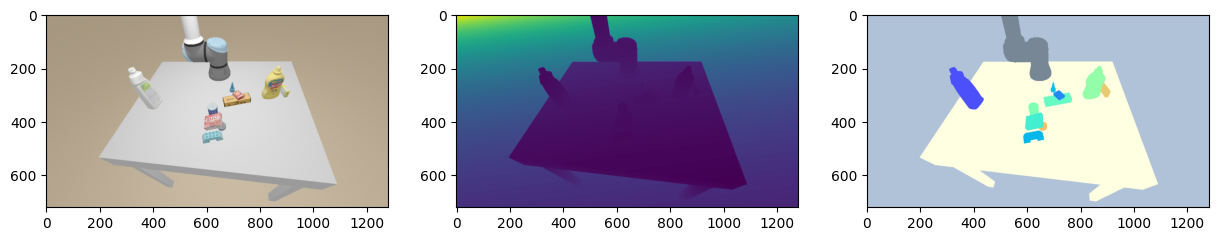

In [3]:

all_data = PoseData(TRAIN_PATH, MODELS_PATH)
# train_data = all_data.txt_split(TRAIN_SPLIT_PATH)
# mesh = train_data.get_mesh(35)
# mesh.show()
data = all_data

scene = data[2, 1, 4]

rgb = scene["color"]()
depth = scene["depth"]()
label = scene["label"]()
meta = scene["meta"]

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation


In [4]:
TEST_ICP = False
if TEST_ICP:

    selection = 1, 1, 4
    scene = data[selection]

    rgb = scene["color"]()
    depth = scene["depth"]()
    label = scene["label"]()
    meta = scene["meta"]

    back_projection = back_project(depth, meta, world=True)

    item = 4
    obj_id = meta["object_ids"][item]

    indices = np.where(label == obj_id)
    obj_pnts = back_projection[indices]
    obj_rgb = rgb[indices]

    NUM_POINTS = len(obj_pnts)
    print(NUM_POINTS)
    SAMPLES = NUM_POINTS # NUM_POINTS # 20_000

    mesh = data.get_mesh(obj_id)
    source_pcd, faces = trimesh.sample.sample_surface(mesh, SAMPLES)

    source_pcd = source_pcd * meta["scales"][obj_id]
    target_pcd = obj_pnts # / meta["scales"][obj_id] # Back Projected

    print(meta["object_names"])

    scale = 0.1
    translate = np.mean(obj_pnts, axis=0)

    attempts = 10
    # Visualization
    T = icp(source_pcd, target_pcd, attempts=attempts)

    print(T)
    gt_T = meta["poses_world"][obj_id]
    print(gt_T)
    print("")

    rre = np.rad2deg(compute_rre(T[:3, :3], gt_T[:3, :3]))
    rte = compute_rte(T[:3, 3], gt_T[:3, 3])
    print(f"rre={rre}, rte={rte}")

    compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], target_pcd, scale=scale, translate=translate)

    # These are individual plots and will also point at the origin (stray points)
    compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], np.zeros((1, 3)), scale=scale, translate=translate)
    compare_points(np.zeros((1, 3)), target_pcd, scale=scale, translate=translate)

    compare_points(source_pcd @ gt_T[:3, :3].T + gt_T[:3, 3], target_pcd,  scale=scale, translate=translate)


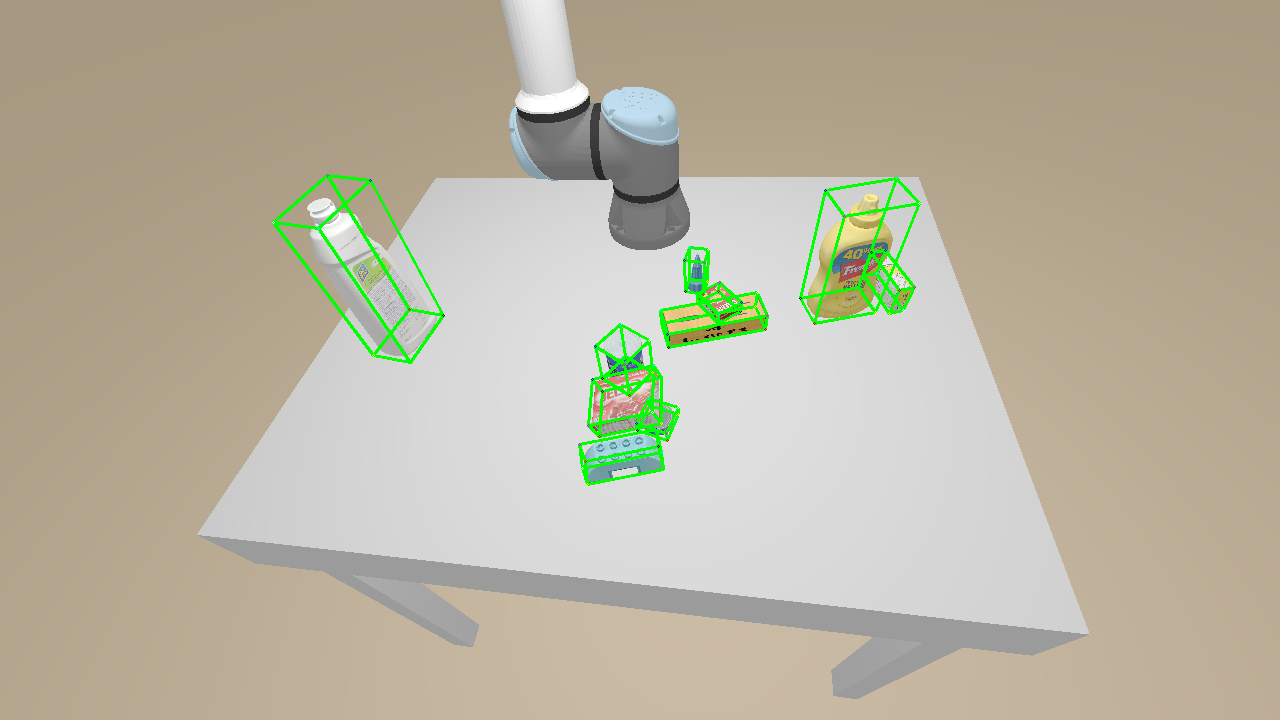

In [5]:
from pose_estimation import draw_projected_box3d

poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))


In [6]:
ICP_RUN = False
if ICP_RUN:
    data = PoseData(TEST_PATH, MODELS_PATH)

    MESH_SAMPLES = None
    ICP_ATTEMPTS = 10

    results = {}
    print(len(data))
    for i, key in enumerate(data.keys()):

        print(i, key)

        l, s, v = key

        scene = data[key]

        rgb = scene["color"]()
        depth = scene["depth"]()
        label = scene["label"]()
        meta = scene["meta"]
        
        back_projection = back_project(depth, meta)

        world_frames = [None] * 79

        object_ids = [object_id for object_id in np.unique(label) if object_id < 79]

        for object_id in object_ids:

            indices = np.where(label == object_id)
            obj_pnts = back_projection[indices]
            obj_rgb = rgb[indices]

            mesh = data.get_mesh(object_id)
            source_pcd, faces = trimesh.sample.sample_surface(mesh, len(obj_pnts) if MESH_SAMPLES in [-1, 0, None, False] else MESH_SAMPLES)

            source_pcd = source_pcd * meta["scales"][object_id]
            target_pcd = obj_pnts

            T = icp(source_pcd, target_pcd, attempts=ICP_ATTEMPTS)

            world_frames[object_id] = T.tolist()

            results[f"{l}-{s}-{v}"] = {"poses_world" : world_frames}


In [25]:
dataset = PoseDataset(TRAIN_PATH, MODELS_PATH)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

print(len(dataset))

for i, (s, t, p, e) in enumerate(data_loader):
    
    print(e)


    index = e[0].int().item()
    key = tuple(torch.tensor(e[2]).tolist())

    rgb = dataset.rgbs[key]
    label = dataset.labels[key]

    

    print(rgb.shape)

    assert 0
    


44505
[tensor([0]), tensor([9]), [tensor([3]), tensor([90]), tensor([9])], {'object': ['bowl'], 'class': ['bowl'], 'source': ['YCB'], 'location': ['models/bowl'], 'metric': ['symmetric_z'], 'min_x': tensor([-0.0807], dtype=torch.float64), 'max_x': tensor([0.0807], dtype=torch.float64), 'min_y': tensor([-0.0806], dtype=torch.float64), 'max_y': tensor([0.0806], dtype=torch.float64), 'min_z': tensor([-0.0275], dtype=torch.float64), 'max_z': tensor([0.0275], dtype=torch.float64), 'width': tensor([0.1615], dtype=torch.float64), 'length': tensor([0.1612], dtype=torch.float64), 'height': tensor([0.0550], dtype=torch.float64), 'visual_symmetry': ['zinf'], 'geometric_symmetry': ['zinf']}]
(720, 1280, 3)


AssertionError: 

In [ ]:



T = icp(source_pcd, target_pcd, attempts=ICP_ATTEMPTS)

world_frames[object_id] = T.tolist()

results[f"{l}-{s}-{v}"] = {"poses_world" : world_frames}


NameError: name 'source_pcd' is not defined

In [ ]:
import json
with open("results.json", "w") as f:
    json.dump(results, f)
